# Speech Emotion Recognition - Data Augmentation

### Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import IPython
import librosa # librosa is a Python library for analyzing audio and music used to extract the data from audio files it later
import librosa.display
from IPython.display import Audio # to play the audio files
plt.style.use('seaborn-white')
from python_speech_features import mfcc

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io

from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers import concatenate
from keras.models import Model
from keras.layers.normalization import layer_normalization
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LSTM
from keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.utils import np_utils, to_categorical

import torch
from pytorch_transformers import GPT2Tokenizer, GPT2LMHeadModel
import speech_recognition as sr

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

C:\Users\TestUser\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


By adding minor changes to my training set, I can generate new data samples with a technique known as data augmentation. I can use techniques such as noise injection, time shifting, pitch and speed changes, etc. to produce data for the audio. Making my models resistant to these disturbances will increase their transferability into real-world situations. The label from the training set must be preserved when adding the disturbances for this to work. First I need to determine which augmentation strategies fit my dataset the best.

In [3]:
Tess_df = pd.read_csv('Tess_df.csv')

Tess_df.head()

,Emotions,Path
0,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
1,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
2,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
3,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
4,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...


In [7]:
def waveplot(array, sampling_rate, emotion):
    
    plt.figure(figsize = (8, 3))
    
    plt.title("Digital Representation of " + emotion, size = 15)
    
    # Visualize a waveform in the time domain. This function constructs a plot which adaptively switches between a raw
    # samples-based view of the signal and an amplitude-envelope view of the signal depending on the time extent of 
    # the plot's viewport.
    librosa.display.waveshow(array, sr = sampling_rate)
    
    plt.show()

In [8]:
def spectrogram(array, sampling_rate, emotion):
    
    # Short-time Fourier transform (STFT). The STFT represents a signal in the time-frequency domain by 
    # computing discrete Fourier transforms (DFT) over short overlapping windows.
    x = librosa.stft(array)
    
    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    x_db_scale = librosa.amplitude_to_db(abs(x))
    
    plt.figure(figsize = (8, 3))
    
    plt.title("Spectrogram of " + emotion, size = 15)
    
    librosa.display.specshow(x_db_scale, sr = sampling_rate, x_axis = 'time', y_axis = 'hz')

In [9]:
def noise(array):
    
    noise_aug = np.random.uniform() * np.amax(array) * 0.06 
    
    array = (noise_aug * np.random.normal(size = array.shape[0])) + array 
    
    return array


def pitch(array, sampling_rate):
    
    return librosa.effects.pitch_shift(y = array, sr = sampling_rate, n_steps = 1.1)


def slow(array, sampling_rate = 0.4):
    
    return librosa.effects.time_stretch(y = array, rate = sampling_rate)


def fast(array, sampling_rate = 1.5):
    
    return librosa.effects.time_stretch(y = array, rate = sampling_rate)


def shift(array):
    
    shift_aug = int(np.random.uniform(low = -20, high = 10) * 1000)
    
    return np.roll(a = array, shift = shift_aug)

In [12]:
path = np.array(Tess_df['Path'])[1]

array, sampling_rate = librosa.load(path = path)

emotion = 'Sad'

#### 1. Normal Audio

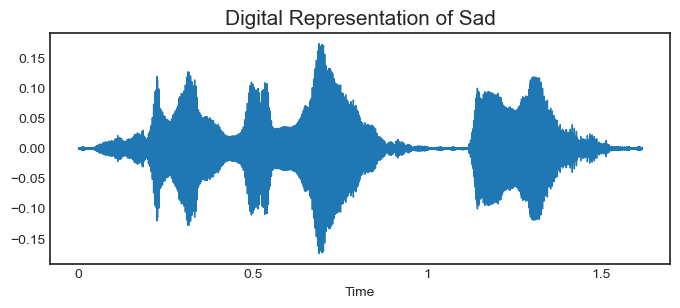

In [13]:
waveplot(array, sampling_rate, emotion)

Audio(path)

#### 2. Noise

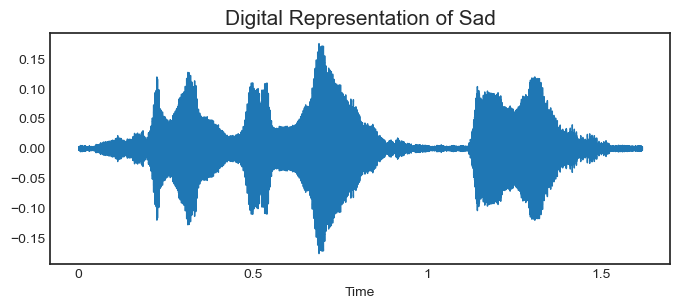

In [14]:
aug = noise(array)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

#### 3. Pitch

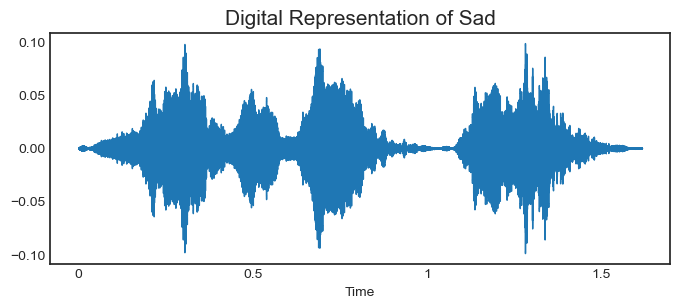

In [15]:
aug = pitch(array, sampling_rate)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

#### 4. Slow Down

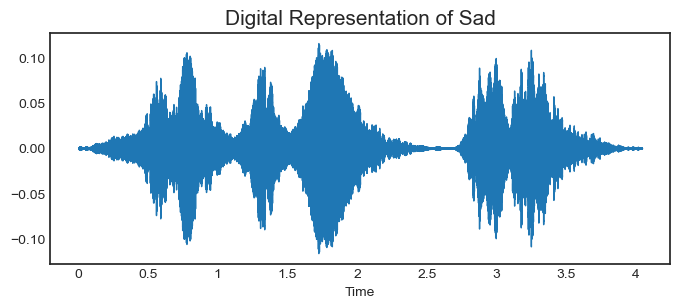

In [16]:
aug = slow(array)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

#### 4. Speed Up

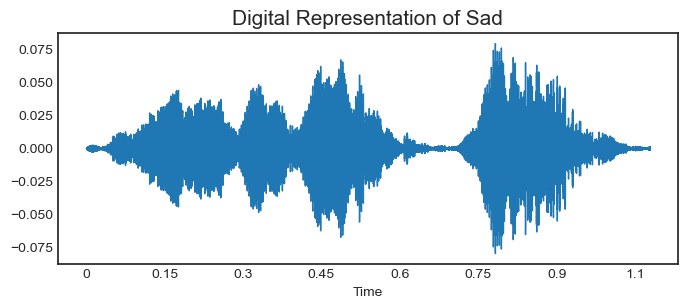

In [17]:
aug = fast(array)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

#### 6. Shift

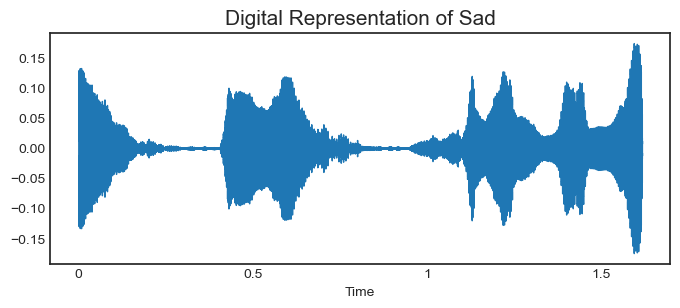

In [18]:
aug = shift(array)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

### Feature Extraction

Since the models cannot simply interpret the information supplied by the audio files, I must turn it into a structure that can be comprehended by them via feature extraction. The three axes of the audio signal—time, amplitude, and frequency—represent its three dimensions.

A crucial step in studying and discovering relationships between various variables is feature extraction. I need to transform the audio data presented into a type that the models can interpret. I can conduct a number of manipulations on the data and sampling rate to derive useful information from them.

In [19]:
def extract_feats(array):
    
    # MFCC
    result = np.array([])
    mfcc = librosa.feature.mfcc(y = array, sr = sampling_rate)
    mfcc_mean = np.mean(mfcc.T, axis = 0)
    result = np.hstack((result, mfcc_mean))  # Horizontal Stack
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y = array)
    zcr_mean = np.mean(zcr.T, axis = 0)
    result = np.hstack((result, zcr_mean))  # Horizontal Stack
    
    # Mel Spectogram
    melspec = librosa.feature.melspectrogram(y = array, sr = sampling_rate)
    melspec_mean = np.mean(melspec.T, axis = 0)
    result = np.hstack((result, melspec_mean))  # Horizontal Stack

    # Root Mean Square Value
    rmsv = librosa.feature.rms(y = array)
    rmsv_mean = np.mean(rmsv.T, axis = 0)
    result = np.hstack((result, rmsv_mean))  # Horizontal Stack
    
    # Chroma
    stft = np.abs(librosa.stft(array))
    chroma_stft = librosa.feature.chroma_stft(S = stft, sr = sampling_rate)
    chroma_stft_mean = np.mean(chroma_stft.T, axis = 0)
    result = np.hstack((result, chroma_stft_mean))  # Horizontal Stack  
    
    # Spectral Centroid
    spectral = librosa.feature.spectral_centroid(y = array)
    spectral_mean = np.mean(spectral.T, axis = 0)
    result = np.hstack((result, spectral_mean))  # Horizontal Stack
     
    return result

In [20]:
def get_feats(path):
    
    # Duration and offset takes care of the noise, pitch, slow down, etc.
    array, sampling_rate = librosa.load(path, duration = 3, offset = 0.6)
    
    # Normal Audio
    resample_norm = extract_feats(array)
    result = np.array(resample_norm)
    
    # Noise
    get_noise = noise(array)
    resample_noise = extract_feats(get_noise)
    result = np.vstack((result, resample_noise))  # Vertical Stack
    
    # Pitch
    get_pitch = pitch(array, sampling_rate)
    resample_pitch = extract_feats(get_pitch)
    result = np.vstack((result, resample_pitch))  # Vertical Stack
    
    # Slow Down
    get_slow = slow(array)
    resample_slow = extract_feats(get_slow)
    result = np.vstack((result, resample_slow))  # Vertical Stack
    
    # Speed Up
    get_fast = fast(array)
    resample_fast = extract_feats(get_fast)
    result = np.vstack((result, resample_fast))  # Vertical Stack
    
    # Shift
    get_shift = shift(array)
    resample_shift = extract_feats(get_shift)
    result = np.vstack((result, resample_shift))  # Vertical Stack
    
    return result

In [21]:
X, y = [], []

for path, emotion in zip(Tess_df['Path'], Tess_df['Emotions']):
    
    feat = get_feats(path)
    
    for feature in feat:
        
        X.append(feature)
        
        y.append(emotion)

In [22]:
len(X)

16800

In [23]:
len(y)

16800

In [24]:
feat = pd.DataFrame(X)

feat['labels'] = y

In [25]:
feat.head()

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,labels
0,-399.535004,76.428391,-23.082157,-18.684132,1.685362,15.067113,-21.209391,-5.796458,-6.386797,3.003888,...,0.434596,0.412372,0.373666,0.568295,0.573150,0.404191,0.469243,0.525294,1487.683221,Angry
1,-261.838864,34.667908,-9.604657,-16.116257,0.213802,5.729191,-7.525563,-6.291940,-2.938743,0.780098,...,0.608866,0.618373,0.462012,0.607227,0.671925,0.530080,0.562091,0.603242,3627.442572,Angry
2,-412.039398,77.262421,-32.583839,-24.591434,4.346249,9.090682,-26.384003,-4.067521,-6.408696,4.251380,...,0.351096,0.422755,0.433503,0.356062,0.580109,0.609401,0.420695,0.462002,1686.632515,Angry
3,-431.256287,75.581871,-25.508471,-20.642477,1.065045,14.736607,-22.362364,-6.727914,-6.420148,3.231606,...,0.413919,0.406536,0.359708,0.557236,0.573689,0.396855,0.461476,0.535765,1548.812463,Angry
4,-391.680115,94.263718,-27.733862,-28.800610,-2.881231,13.102319,-28.031700,-10.077882,-9.727766,2.450062,...,0.425077,0.347824,0.328270,0.633562,0.555491,0.397686,0.483802,0.523931,1539.644752,Angry


In [26]:
feat.to_csv('feat.csv', index = False)